In [2]:




from numpy import array
from numpy import argmax
from os import listdir
from pickle import dump, load
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import load_img, img_to_array

from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM, RNN, GRU, Embedding, Dropout
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers.merge import add
import string
import numpy as np
import PIL.Image
from nltk.translate.bleu_score import corpus_bleu

In [3]:
# Extract features from each photo in the directory
def extract_features(directory):
    
    # Loading the model
    from IPython.core.display import display, HTML
    display(HTML("""<a href="http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006">ResNet50 Architecture</a>"""))
    model = ResNet50(include_top=False,weights='imagenet',input_shape=(224,224,3),pooling='avg')

    
    # Summarizing the model 
    print(model.summary())

    # Extracting features from each photo and storing it in a dictionary 
    features = dict()

    for name in listdir(directory):

        # Defining the path of the image 
        filename = directory + '/' + name
        
        # Loading an image and converting it into size 224 * 224
        image = load_img(filename, target_size=(224, 224))
        
        # Converting the image pixels into a numpy array
        image = img_to_array(image)
        
        # Reshaping data for the model
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

        
        # Preprocessing the images for the VGG model
        # The preprocess_input function is meant to adequate your image to the format the model requires.
        image = preprocess_input(image)

        # Getting features of an image
        feature = model.predict(image, verbose=0)
        
        # Getting the image name
        image_id = name.split('.')[0]

        # Storing the feature corresponding to the image in the dictionary
        features[image_id] = feature
        
        # print('>%s' % name)
        
    return features

In [4]:
# Defining the directory we are using
directory = '../input/flickr8k_dataset/Flicker8k_Dataset'

# Extracting features from all the images
features = extract_features(directory)

print('Extracted Features: ', len(features))

# Dumping the features in a pickle file for further use
dump(features, open('features.pkl', 'wb'))

Instructions for updating:
Colocations handled automatically by placer.
94658560/94653016 [==============================] - 5s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[

Extracted Features:  8091


In [5]:
listdir('../input')

['Flickr8k_text', 'flickr8k_text', 'Flickr8k_Dataset', 'flickr8k_dataset']

In [6]:
# Loading the file containg all the descriptions into memory

def load_doc(filename):
    # Opening the file as read only
    file = open(filename, 'r')

    # Reading all text and storing it.
    text = file.read()

    # Closing the file
    file.close()
    
    return text


In [7]:
def photo_to_description_mapping(descriptions):
    
    # Dictionary to store the mapping of photo identifiers to descriptions
    description_mapping = dict()
    
    # Iterating through each line of the descriptions
    for line in descriptions.split('\n'):
        
        # Splitting the lines by white space
        words = line.split()
        
        # Skipping the lines with length less than 2
        if len(line)<2:
            continue
            
        # The first word is the image_id and the rest are the part of the description of that image
        image_id, image_description = words[0], words[1:]
        
        # Retaining only the name of the image and removing the extension from it
        image_id = image_id.split('.')[0]
        
        # Image_descriptions contains comma separated words of the description, hence, converting it back to string
        image_description = ' '.join(image_description)
        
        # There are multiple descriptions per image, 
        # hence, corresponding to every image identifier in the dictionary, there is a list of description
        # if the list does not exist then we need to create it
        
        if image_id not in description_mapping:
            description_mapping[image_id] = list()
            
        # Now storing the descriptions in the mapping
        description_mapping[image_id].append(image_description)
    
    return description_mapping

In [8]:
def clean_descriptions(description_mapping):
    
    # Preapring a translation table for removing all the punctuation
    table = str.maketrans('','', string.punctuation)
    
    # Traversing through the mapping we created
    for key, descriptions in description_mapping.items():
        for i in range(len(descriptions)):
            description = descriptions[i]
            description = description.split()
            
            # Converting all the words to lower case
            description = [word.lower() for word in description]
            
            # Removing the punctuation using the translation table we made
            description = [word.translate(table) for word in description]
            
            # Removing the words with length =1
            description = [word for word in description if len(word)>1]
            
            # Removing all words with number in them
            description = [word for word in description if word.isalpha()]
            
            # Converting the description back to string and overwriting in the descriptions list
            descriptions[i] = ' '.join(description)

In [9]:
# Converting the loaded descriptions into a vocabulary of words

def to_vocabulary(descriptions):
    
    # Build a list of all description strings
    all_desc = set()
    
    for key in descriptions.keys():
        [all_desc.update(d.split()) for d in descriptions[key]]
    
    return all_desc

In [10]:
# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

In [11]:
filename = '../input/flickr8k_text/Flickr8k.token.txt'

# Loading descriptions
doc = load_doc(filename)

# Parsing descriptions
descriptions = photo_to_description_mapping(doc)
print('Loaded: %d ' % len(descriptions))

# Cleaning the descriptions
clean_descriptions(descriptions)

# Summarizing the vocabulary
vocabulary = to_vocabulary(descriptions)
print('Vocabulary Size: %d' % len(vocabulary))

# Saving to the file
save_descriptions(descriptions, 'descriptions.txt')

Loaded: 8092 
Vocabulary Size: 8763


In [12]:
# Function for loading a file into memory and returning text from it
def load_file(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

# Function for loading a pre-defined list of photo identifiers
def load_photo_identifiers(filename):
    
    # Loading the file containing the list of photo identifier
    file = load_file(filename)
    
    # Creating a list for storing the identifiers
    photos = list()
    
    # Traversing the file one line at a time
    for line in file.split('\n'):
        if len(line) < 1:
            continue
        
        # Image name contains the extension as well but we need just the name
        identifier = line.split('.')[0]
        
        # Adding it to the list of photos
        photos.append(identifier)
        
    # Returning the set of photos created
    return set(photos)




def load_clean_descriptions(filename, photos):
    
    #loading the cleaned description file
    file = load_file(filename)
    
    #creating a dictionary of descripitions for storing the photo to description mapping of train images
    descriptions = dict()
    
    #traversing the file line by line
    for line in file.split('\n'):
        # splitting the line at white spaces
        words = line.split()
        
        # the first word will be the image name and the rest will be the description of that particular image
        image_id, image_description = words[0], words[1:]
        
        # we want to load only those description which corresponds to the set of photos we provided as argument
        if image_id in photos:
            #creating list of description if needed
            if image_id not in descriptions:
                descriptions[image_id] = list()
            
           
            
            desc = 'startseq ' + ' '.join(image_description) + ' endseq'
            descriptions[image_id].append(desc)
            
    return descriptions

# function to load the photo features created using the VGG16 model
def load_photo_features(filename, photos):
    
    #this will load the entire features
    all_features = load(open(filename, 'rb'))
    
    #we are interested in loading the features of the required photos only
    features = {k: all_features[k] for k in photos}
    
    return features

In [13]:
filename = '../input/flickr8k_text/Flickr_8k.trainImages.txt'

train = load_photo_identifiers(filename)
print('Dataset: ',len(train))

train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=', len(train_descriptions))

train_features = load_photo_features('features.pkl', train)
print('Photos: train=', len(train_features))

Dataset:  6000
Descriptions: train= 6000
Photos: train= 6000


In [14]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc



def create_tokenizer(descriptions):
    lines = to_lines(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [15]:
tokenizer = create_tokenizer(train_descriptions)

vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: ', vocab_size)

Vocabulary Size:  7579


In [16]:
#calculated the length of description with most words
def max_lengthTEMP(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)

In [17]:

def data_generator(descriptions, photos, tokenizer, max_length):
    while 1:
        for key, description_list in descriptions.items():
            #retrieve photo features
            photo = photos[key][0]
            input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, photo)
            yield [[input_image, input_sequence], output_word]

            

def create_sequences(tokenizer, max_length, desc_list, photo):
    X1, X2, y = list(), list(), list()
    # walk through each description for the image
    for desc in desc_list:
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            # store
            X1.append(photo)
            X2.append(in_seq)
            y.append(out_seq)
    return array(X1), array(X2), array(y)

In [18]:
from keras.utils import plot_model
# define the captioning model
def define_model(vocab_size, max_length):
    
    # feature extractor model
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    # sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    # decoder model
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    
    # summarize model
    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)
    
    return model

In [19]:

filename = '../input/flickr8k_text/Flickr_8k.trainImages.txt'
train = load_photo_identifiers(filename)
print('Dataset: ', len(train))
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=', len(train_descriptions))
train_features = load_photo_features('features.pkl', train)
print('Photos: train=', len(train_features))
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size:', vocab_size)
max_length = max_lengthTEMP(train_descriptions)
print('Description Length: ', max_length)

model = define_model(vocab_size, max_length)
epochs = 20
steps = len(train_descriptions)
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('model_' + str(i) + '.h5')

Dataset:  6000
Descriptions: train= 6000
Photos: train= 6000
Vocabulary Size: 7579
Description Length:  34
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 256)      1940224     input_3[0][0]                    
_____________________________________________________________________________________

In [20]:
listdir()

['model_19.h5',
 'model_5.h5',
 'model.png',
 'model_12.h5',
 'model_10.h5',
 'features.pkl',
 '__notebook_source__.ipynb',
 'model_9.h5',
 'model_6.h5',
 'model_8.h5',
 'model_18.h5',
 'model_1.h5',
 'model_2.h5',
 'model_16.h5',
 'model_13.h5',
 'model_11.h5',
 'model_3.h5',
 'model_0.h5',
 'descriptions.txt',
 'model_7.h5',
 'model_17.h5',
 'model_14.h5',
 'model_15.h5',
 'model_4.h5']

In [21]:
#this function maps an integer to a word
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

#The function below generates a textual description given a trained model, 
#and a given prepared photo as input. It calls the function word_for_id() 
#in order to map an integer prediction back to a word.
def generate_desc(model, tokenizer, photo, max_length):
    #start tge generation process
    in_text = 'startseq'
    #iterating over the max_length since the maximum length of the description can be that only
    for i in range(max_length):
        #integer ncoding input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        #padding the input
        sequence = pad_sequences([sequence], maxlen=max_length)
        #predicting next word
        #the predict function will return probability
        prob = model.predict([photo,sequence], verbose=0)
        #converting the probability to integer
        prob = argmax(prob)
        #calling the word_for_id function in order to map integer to word
        word = word_for_id(prob, tokenizer)
        #breaking if word cannot be mapped
        if word is None:
            break
        #appending as input
        in_text += ' ' + word
        #break if end is predicted
        if word == 'endseq':
            break
    return in_text

#the below function evaluates the skill of the model
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
    actual, predicted = list(), list()
    for key, desc_list in descriptions.items():
        prediction = generate_desc(model, tokenizer, photos[key], max_length)
        actual_desc = [d.split() for d in desc_list]
        actual.append(actual_desc)
        predicted.append(prediction.split())

    print('BLEU-1: ', corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: ', corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: ', corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: ', corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))
    
def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)

In [22]:
filename = '../input/flickr8k_text/Flickr_8k.trainImages.txt'
train = load_photo_identifiers(filename)
print('Dataset: ', len(train))
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=', len(train_descriptions))
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: ', vocab_size)
max_length = max_lengthTEMP(train_descriptions)
print('Description Length: ,', max_length)

filename = '../input/flickr8k_text/Flickr_8k.testImages.txt'
test = load_photo_identifiers(filename)
print('Dataset: ', len(test))
test_descriptions = load_clean_descriptions('descriptions.txt', test)
print('Descriptions: test=', len(test_descriptions))
test_features = load_photo_features('features.pkl', test)
print('Photos: test=', len(test_features))

filename = 'model_12.h5'
model = load_model(filename)
evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)

Dataset:  6000
Descriptions: train= 6000
Vocabulary Size:  7579
Description Length: , 34
Dataset:  1000
Descriptions: test= 1000
Photos: test= 1000
BLEU-1:  0.5202807401330781
BLEU-2:  0.2772368080541409
BLEU-3:  0.18590514434903624
BLEU-4:  0.08336721539270532


In [23]:
filename = '../input/flickr8k_text/Flickr_8k.trainImages.txt'
train = load_photo_identifiers(filename)
print('Dataset: ', len(train))
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=', len(train_descriptions))
tokenizer = create_tokenizer(train_descriptions)
dump(tokenizer, open('tokenizer.pkl', 'wb'))

Dataset:  6000
Descriptions: train= 6000


In [36]:
def extract_features(filename):
    from IPython.core.display import display, HTML
    display(HTML("""<a href="http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006">ResNet50 Architecture</a>"""))
    model = ResNet50(include_top=False,weights='imagenet',input_shape=(224,224,3),pooling='avg')
    image = load_img(filename, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    feature = model.predict(image, verbose=0)
    return feature

def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = argmax(yhat)
        word = word_for_id(yhat, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'endseq':
            break
    return in_text

tokenizer = load(open('tokenizer.pkl', 'rb'))
max_length = 34

In [41]:
#listdir("../input/flickr8k-dataset/Flicker8k_Dataset/2281075738_230892b241.jpg")

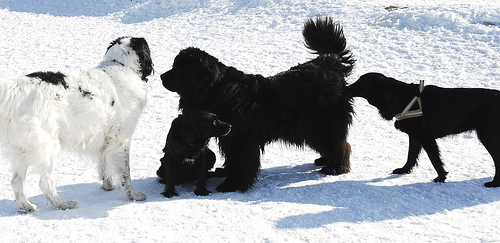

startseq two dogs are playing in the snow endseq


In [46]:
model = load_model('model_19.h5')
path = '../input/flickr8k_dataset/Flicker8k_Dataset/317383917_d8bfa350b6.jpg'

from IPython.display import Image, display
z = Image(path)
display(z)
photo = extract_features(path)
   
description = generate_desc(model, tokenizer, photo, max_length)
print(description)

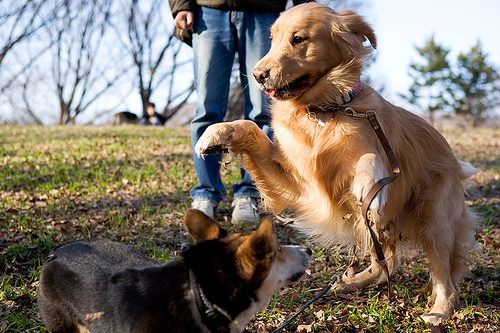

startseq dog is running through the grass endseq


In [47]:
model = load_model('model_19.h5')
path = '../input/flickr8k_dataset/Flicker8k_Dataset/387830531_e89c192b92.jpg'

from IPython.display import Image, display
z = Image(path)
display(z)
photo = extract_features(path)
   
description = generate_desc(model, tokenizer, photo, max_length)
print(description)

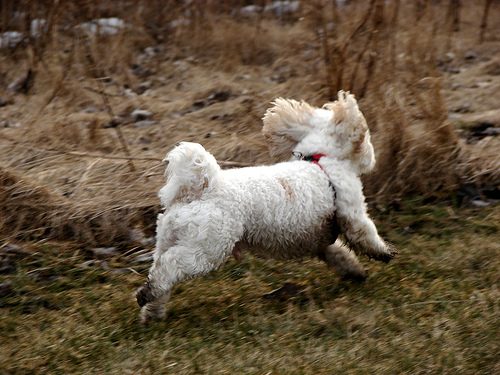

In [ ]:
model = load_model('model_19.h5')
path = '../input/flickr8k_dataset/Flicker8k_Dataset/3168123064_d1983b8f92.jpg'

from IPython.display import Image, display
z = Image(path)
display(z)
photo = extract_features(path)
   
description = generate_desc(model, tokenizer, photo, max_length)
print(description)

In [44]:
for i in test:
    print(i)

2510020918_b2ca0fb2aa
2663794355_e726ec7e05
997722733_0cb5439472
3396157719_6807d52a81
2370481277_a3085614c9
241345905_5826a72da1
2646116932_232573f030
2084217208_7bd9bc85e5
3270691950_88583c3524
197107117_4b438b1872
3584930205_a3f58a4b7c
497791037_93499238d8
317383917_d8bfa350b6
2844641033_dab3715a99
359837950_9e22ffe6c2
3250695024_93e8ab7305
2595186208_9b16fa0ee3
1402640441_81978e32a9
1626754053_81126b67b6
2283966256_70317e1759
2101457132_69c950bc45
1765164972_92dac06fa9
2228022180_9597b2a458
166507476_9be5b9852a
2410320522_d967f0b75c
3568197730_a071d7595b
2160266952_a2ab39191b
2796801478_8ebd7e550b
670609997_5c7fdb3f0b
3070011270_390e597783
2648165716_02e2e74fd6
387830531_e89c192b92
1287073593_f3d2a62455
3437147889_4cf26dd525
2878190821_6e4e03dc5f
3256275785_9c3af57576
3530843182_35af2c821c
132489044_3be606baf7
3619416477_9d18580a14
2731171552_4a808c7d5a
3504881781_6a842e043b
2588927489_f4da2f11ec
561940436_64d6fc125d
486917990_72bd4069af
1408958345_68eea9a4e4
3694093650_547259731e


In [ ]:
#model = VGG16()

    # Removing the last layer from the loaded model as we require only the features not the classification 
    #model.layers.pop()
    #model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
    #4096